In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# from fastai.imports import *
# from fastai.structured import *
from fbprophet import Prophet
# you probably have to install Prophet: conda install -c conda-forge fbprophet
# you may also have to set up command line tools. Only do this if you have to: xcode-select --install

# def ignore_warn(*args, **kwargs):
#     pass
# warnings.warn = ignore_warn

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

start_time = pd.datetime.now()

import statsmodels.api as sm
# Initialize plotly
init_notebook_mode(connected=True)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
os.getcwd()

'/Users/mengtianhu/Downloads'

In [4]:
df_raw = pd.read_csv('06_2010_625_Variables_BoxL.csv', low_memory=False, parse_dates=['Date'], index_col=['Date'])
#subs = pd.read_csv('sample_submission.csv')

In [5]:
df_raw.head(10)

,Unnamed: 0,Hour,Temperature,Load,month,weekday,Distance,TemperatureLag1,TemperatureLag2,TemperatureLag24,...,holiday.temp_mean_6_0.5,holiday.temp_mean_6_2,holiday.temp_mean_6_3,holiday.temp_mean_12_0.5,holiday.temp_mean_12_2,holiday.temp_mean_12_3,holiday.temp_mean_24_0.5,holiday.temp_mean_24_2,holiday.temp_mean_24_3,Load_BoxCox
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,0,1,25.00,10737.0,January,Tuesday,27.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.469295
2008-01-01,1,2,24.00,10348.0,January,Tuesday,28.00,25.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.128732
2008-01-01,2,3,23.00,9997.0,January,Tuesday,29.00,24.00,25.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.812981
2008-01-01,3,4,23.00,9760.0,January,Tuesday,29.00,23.00,24.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.594984
2008-01-01,4,5,23.00,9624.0,January,Tuesday,29.00,23.00,23.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.468065
2008-01-01,5,6,22.33,9619.0,January,Tuesday,29.67,23.00,23.00,NaN,...,4.836149,547.014136,12793.748953,NaN,NaN,NaN,NaN,NaN,NaN,33.463373
2008-01-01,6,7,21.00,9794.0,January,Tuesday,31.00,22.33,23.00,NaN,...,4.766725,516.274136,11730.608829,NaN,NaN,NaN,NaN,NaN,NaN,33.626503
2008-01-01,7,8,21.00,10021.0,January,Tuesday,31.00,21.00,22.33,NaN,...,4.713986,493.802469,10973.113875,NaN,NaN,NaN,NaN,NaN,NaN,33.834837
2008-01-01,8,9,21.00,9984.0,January,Tuesday,31.00,21.00,21.00,NaN,...,4.678497,479.099136,10486.681591,NaN,NaN,NaN,NaN,NaN,NaN,33.801126


In [6]:
df_raw=df_raw.drop('Unnamed: 0',axis=1)

In [7]:
df_raw.dtypes

Hour                          int64
Temperature                 float64
Load                        float64
month                        object
weekday                      object
Distance                    float64
TemperatureLag1             float64
TemperatureLag2             float64
TemperatureLag24            float64
TemperatureLag48            float64
Temperature_2_Lag           float64
Temperature_2_Lag1          float64
Temperature_2_Lag2          float64
Temperature_2_Lag24         float64
Temperature_2_Lag48         float64
Temperature_3_Lag           float64
Temperature_3_Lag1          float64
Temperature_3_Lag2          float64
Temperature_3_Lag24         float64
Temperature_3_Lag48         float64
Temperature_0.5_Lag         float64
Temperature_0.5_Lag1        float64
Temperature_0.5_Lag2        float64
Temperature_0.5_Lag24       float64
Temperature_0.5_Lag48       float64
DistanceLag1                float64
DistanceLag2                float64
DistanceLag24               

In [8]:
# str(df_raw['Hour'])

In [9]:
# df_raw['ds']=df_raw.index+' '+str(df_raw['Hour'])

In [10]:
df_raw.shape

(43848, 624)

In [11]:
df_train = df_raw[df_raw.index<'2011-01-01']
df_test = df_raw[(df_raw.index>='2011-01-01') & (df_raw.index<'2012-01-01')]

In [12]:
df_test.head()

,Hour,Temperature,Load,month,weekday,Distance,TemperatureLag1,TemperatureLag2,TemperatureLag24,TemperatureLag48,...,holiday.temp_mean_6_0.5,holiday.temp_mean_6_2,holiday.temp_mean_6_3,holiday.temp_mean_12_0.5,holiday.temp_mean_12_2,holiday.temp_mean_12_3,holiday.temp_mean_24_0.5,holiday.temp_mean_24_2,holiday.temp_mean_24_3,Load_BoxCox
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,39.33,9627.0,January,Saturday,12.67,41.33,48.33,45.33,35.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.470880
2011-01-01,2,36.67,9268.0,January,Saturday,15.33,39.33,41.33,45.33,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.129259
2011-01-01,3,35.33,9007.0,January,Saturday,16.67,36.67,39.33,46.33,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.874523
2011-01-01,4,32.00,8737.0,January,Saturday,20.00,35.33,36.67,46.00,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.605030
2011-01-01,5,29.67,8689.0,January,Saturday,22.33,32.00,35.33,44.67,35.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.556459


In [13]:
df_raw.describe()

,Hour,Temperature,Load,Distance,TemperatureLag1,TemperatureLag2,TemperatureLag24,TemperatureLag48,Temperature_2_Lag,Temperature_2_Lag1,...,holiday.temp_mean_6_0.5,holiday.temp_mean_6_2,holiday.temp_mean_6_3,holiday.temp_mean_12_0.5,holiday.temp_mean_12_2,holiday.temp_mean_12_3,holiday.temp_mean_24_0.5,holiday.temp_mean_24_2,holiday.temp_mean_24_3,Load_BoxCox
count,43848.000000,43848.000000,35064.000000,43848.000000,43847.000000,43846.000000,43824.000000,43800.000000,43848.000000,43847.000000,...,43843.000000,43843.000000,43843.000000,43837.000000,43837.000000,43837.000000,43825.000000,43825.000000,43825.000000,35064.000000
mean,12.500000,50.334529,11639.447525,17.300641,50.335259,50.335966,50.346852,50.361783,2953.131173,2953.193938,...,0.153987,61.569738,4065.693620,0.153464,61.036809,3999.210800,0.152521,60.120615,3884.846887,35.091289
std,6.922265,20.490564,2317.204003,11.104868,20.490228,20.489927,20.489070,20.483996,2041.361709,2041.342273,...,1.024616,536.285543,41129.353004,1.022452,528.995382,39993.350580,1.019119,516.812764,38245.902480,1.806090
min,1.000000,-17.330000,7223.000000,0.000000,-17.330000,-17.330000,-17.330000,-17.330000,-300.328900,-300.328900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.963908
25%,6.750000,34.330000,9962.000000,8.330000,34.330000,34.330000,34.330000,34.330000,1178.548900,1178.548900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.781037
50%,12.500000,51.000000,11450.000000,16.330000,51.000000,51.000000,51.000000,51.000000,2601.000000,2601.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.069898
75%,18.250000,67.000000,12811.000000,24.330000,67.000000,67.000000,67.000000,67.000000,4489.000000,4489.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.141571
max,24.000000,101.000000,23753.000000,69.330000,101.000000,101.000000,101.000000,101.000000,10201.000000,10201.000000,...,9.947110,9790.113025,968682.733259,9.814955,9280.111111,893984.037037,9.469270,8040.185834,720940.013149,42.577278


In [14]:
y = df_train['Load']

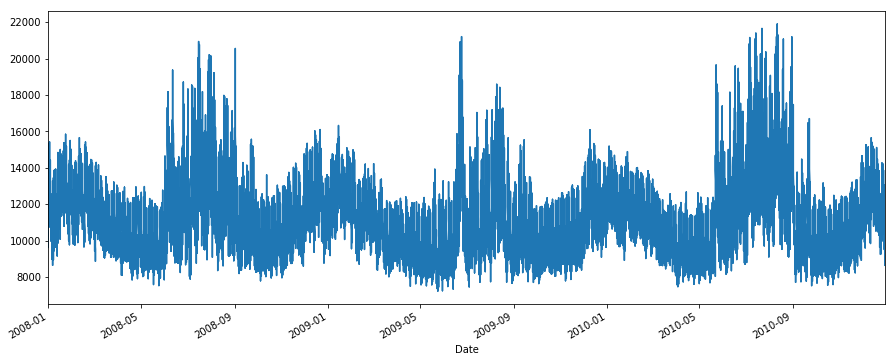

In [15]:
y.plot(figsize=(15, 6),);
#The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year
# and again low at the end of the year...
#There is always an upward trend within any single year with a couple of low months in the mid of the year...

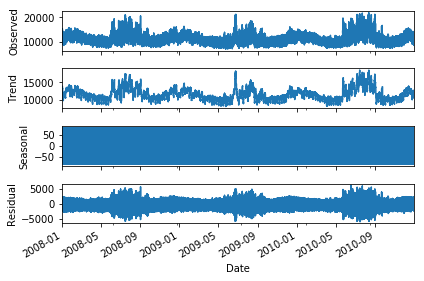

In [16]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='additive',freq=30)
decomposition.plot();
#The plot clearly shows that the sales is unstable, along with its obvious seasonality.;

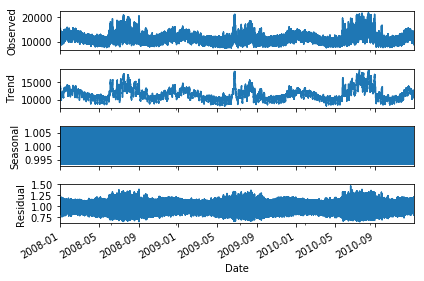

In [17]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',freq=30)
decomposition.plot();
#The plot above clearly shows that the sales is unstable, along with its obvious seasonality.;

## Prophet

*(From the Docs Itself)*

let's take a closer look at how Prophet works. In its essence, this library utilizes the additive regression model $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$ where:

- Trend $g(t)$ models non-periodic changes.
- Seasonality $s(t)$ represents periodic changes.
- Holidays component $h(t)$ contributes information about holidays and events.


> ### Trend     $g(t)$

The Prophet library implements two possible trend models for $g(t)$.

The first one is called Nonlinear, Saturating Growth. It is represented in the form of the logistic growth model:

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$ where:

- $C$ is the carrying capacity (that is the curve's maximum value).
- $k$ is the growth rate (which represents "the steepness" of the curve).
- $m$ is an offset parameter.

> ### Seasonality    $s(t)$

The seasonal component $s(t)$ provides a flexible model of periodic changes due to weekly and yearly seasonality. Yearly seasonality model in Prophet relies on Fourier series.

> ### Holidays and Events      $h(t)$

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

> ### Error    $\epsilon(t)$

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In describing these time series, we have used words such as $“trend”$ and $“seasonal”$ which need to be defined more carefully.

>Trend

 A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.
 
> Seasonal

 A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency.

> Cycle

A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

In [18]:
df = y.reset_index()
df.columns = ['ds', 'y']

In [19]:
df.head()

,ds,y
0,2008-01-01,10737.0
1,2008-01-01,10348.0
2,2008-01-01,9997.0
3,2008-01-01,9760.0
4,2008-01-01,9624.0


In [20]:
df['holiday'] = df_train.reset_index()['holiday'].copy()
df['Week'] = df_train.reset_index()['weekday_Mean_Encoding'].copy()
df['month.week'] = df_train.reset_index()['month.week_Mean_Encoding'].copy()

In [21]:
df.groupby(['Week','holiday','month.week'])['y'].mean().reset_index().head(10)

,Week,holiday,month.week,y
0,10381.732639,0,11463.402612,10119.799769
1,10381.732639,0,11583.101799,10531.868056
2,10381.732639,0,11690.820106,10485.425926
3,10381.732639,0,11697.668155,10327.652778
4,10381.732639,0,11713.493882,10544.006944
5,10853.614850,0,11463.402612,10552.725694
6,10853.614850,0,11583.101799,10669.440972
7,10853.614850,0,11690.820106,11009.664352
8,10853.614850,0,11697.668155,10920.340278
9,10853.614850,0,11713.493882,10993.120370


In [22]:
df_test.shape

(8760, 624)

In [27]:
prediction_size = df_test.shape[0]
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y,holiday,Week,month.week
17541,2009-12-31,12735.0,0,12077.554671,11583.101799
17542,2009-12-31,12363.0,0,12077.554671,11583.101799
17543,2009-12-31,11906.0,0,12077.554671,11583.101799


In [28]:
m = Prophet(yearly_seasonality=12, weekly_seasonality=True, daily_seasonality=True)
m.fit(train_df[['ds','y']]);

/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [29]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
26301,2033-12-23
26302,2033-12-24
26303,2033-12-25


In [30]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
26301,2033-12-23,26573.985949,-149390.798368,198563.461140,-152450.399999,196215.461938,1814.585827,1814.585827,1814.585827,730.023756,...,313.163705,313.163705,313.163705,771.398365,771.398365,771.398365,0.0,0.0,0.0,28388.571776
26302,2033-12-24,26575.820850,-151886.483684,197346.805388,-152486.351342,196255.577106,596.902207,596.902207,596.902207,730.023756,...,-786.583433,-786.583433,-786.583433,653.461884,653.461884,653.461884,0.0,0.0,0.0,27172.723058
26303,2033-12-25,26577.655752,-152753.988850,197597.452068,-152522.302684,196295.692273,-16.119578,-16.119578,-16.119578,730.023756,...,-1281.115387,-1281.115387,-1281.115387,534.972053,534.972053,534.972053,0.0,0.0,0.0,26561.536174


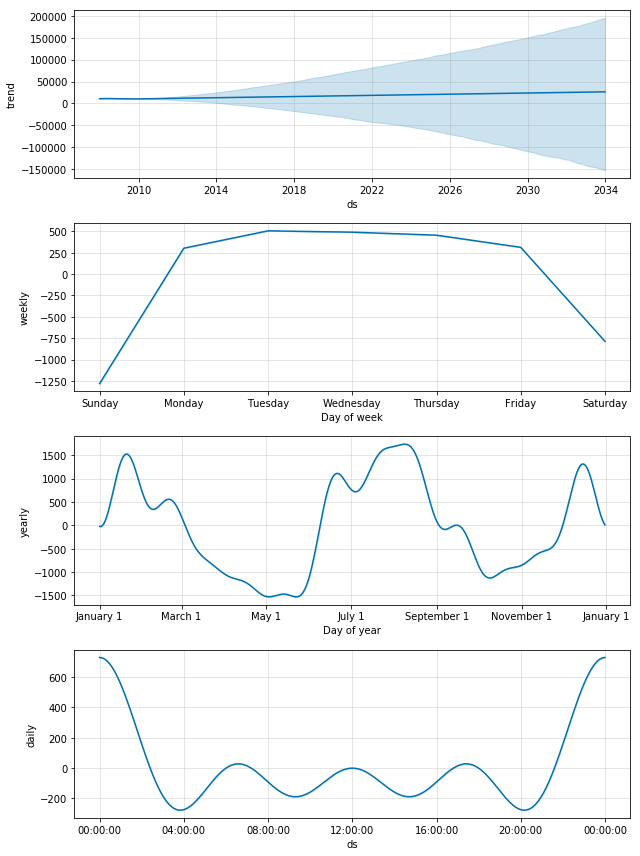

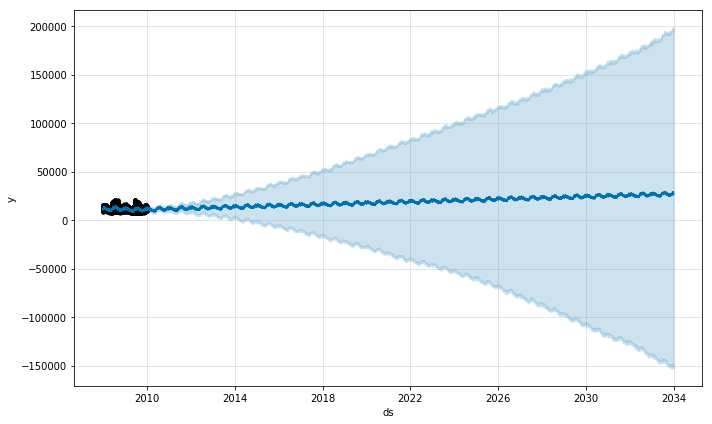

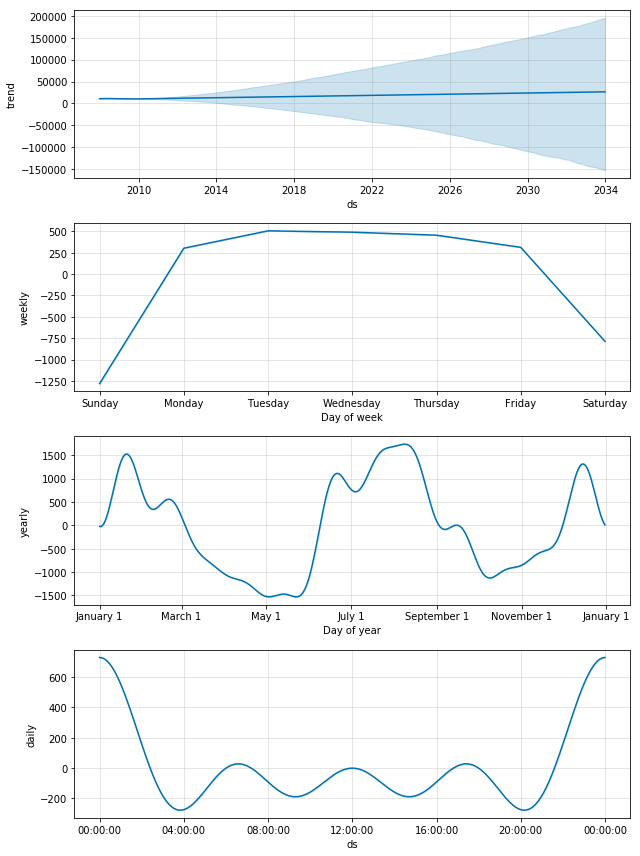

In [31]:
m.plot(forecast)
m.plot_components(forecast)

In [32]:
train_df[['ds','holiday']]

,ds,holiday
0,2008-01-01,1
1,2008-01-01,1
2,2008-01-01,1
3,2008-01-01,1
4,2008-01-01,1
5,2008-01-01,1
6,2008-01-01,1
7,2008-01-01,1
8,2008-01-01,1
9,2008-01-01,1


In [33]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [34]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(3)

,yhat,yhat_lower,yhat_upper,y,holiday,Week,month.week
ds,,,,,,,
2033-12-23,28388.571776,-149390.798368,198563.461140,NaN,NaN,NaN,NaN
2033-12-24,27172.723058,-151886.483684,197346.805388,NaN,NaN,NaN,NaN
2033-12-25,26561.536174,-152753.988850,197597.452068,NaN,NaN,NaN,NaN


In [35]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [36]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print('Non Holiday', err_name, err_value)

Non Holiday MAPE 10.15279792238077
Non Holiday MAE 1121.1376290917576
